# Decomposition of the data:

### Decompostion models:
- Additive : Trend + Seasoality + Error
- Multiplicatve : Trend * Seasonality * Error

#### the seasonality on our data is almost have the same magintude we have chosen the additive model to decompose the data

## Decompostion Steps:
- Detrending the data:
    1. get the trend usnig Smoothing or Regresion models (we have chosen the regression)
    2. detrending the data by subtracting the regression results on the data from the observed ones
- Deseasonal the data:
    1. get the seasonality factor for every time stamp by taking the averages over the timestamp
    2. deaseasonalize the data by subtracting the seasonal factor

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [153]:
def get_hour(datetime_o):
    """
    this function to get the hour of the day to use it as an additional regressor
    """
    return datetime_o.hour
def get_min(datetime_o):
    """
    this function to get the hour of the day to use it as an additional regressor
    """
    return datetime_o.minute
def get_day(datetime_o):
    """
    this function to get the the day to use it as an additional regressor
    """
    return datetime_o.day
def get_weekday(datetime_o):
    """
    this function to get the the day of the week to use it as an additional regressor
    """
    return datetime_o.weekday()

In [154]:
df = pd.read_csv("final_data.csv")
df["time"] = pd.to_datetime(df["time"])
df.rename(columns = {"indernet_cdr": "internet_cdr"}, inplace = True)

In [155]:
df

,grid_square,internet_cdr,time
0,5056,517.607260,2013-11-01 00:00:00
1,5056,314.551305,2013-11-01 00:10:00
2,5056,341.527327,2013-11-01 00:20:00
3,5056,450.012415,2013-11-01 00:30:00
4,5056,312.166782,2013-11-01 00:40:00
...,...,...,...
80347,5258,153.632216,2014-01-01 23:10:00
80348,5258,125.178334,2014-01-01 23:20:00
80349,5258,104.560788,2014-01-01 23:30:00
80350,5258,132.476372,2014-01-01 23:40:00


In [156]:
df_f = df.groupby("grid_square")
groups = list(df_f.groups)
chosen_grids = [5056,5057,5058,5156,5157,5158,5256,5257,5258]
final_grid = pd.DataFrame()
seasonality = {}
for grid in chosen_grids:
    df1 = pd.DataFrame()
    #get the grid with the last 12 days excluded
    df_r = df_f.get_group(grid)[:-12*144]
    #### Detrending ########

    # 1- Get trend by linear Regression
    LR = LinearRegression()
    LR.fit(np.array(df_r.index).reshape(-1,1), df_r["internet_cdr"])
    trend = LR.predict((np.array(df_r.index).reshape(-1,1)))
    # 2- Detrending
    df_r["detrended"] = df_r["internet_cdr"] - trend

    # 1- Getting seasonal features
    df_r["day_of_week"] = df_r["time"].apply(get_weekday)
    df_r["hour"] = df_r["time"].apply(get_hour)
    df_r["minute"] = df_r["time"].apply(get_min)
    # 2- getting seasonal factors:
    df_g = df_r.groupby(["day_of_week", "hour", "minute"])
    means = df_g["detrended"].mean()
    seasonality[grid] = means
    time_stamps = list(df_g.groups)
    # 3- Decompose: 
    for ts in time_stamps:
        df_g1 = df_g.get_group(ts)
        #### Deseasonal the data #######
        seasonal_fator = means[ts]
        df_g1["deseasonnal"] = df_g1["detrended"] - seasonal_fator
        df1 = pd.concat([df_g1,df1 ])
    # 4- Redordering the Data
    df1 = df1.sort_values("time")
    # Final DataFrame
    final_grid = pd.concat([final_grid, df1])

In [158]:
final_grid

,grid_square,internet_cdr,time,detrended,day_of_week,hour,minute,deseasonnal
0,5056,517.607260,2013-11-01 00:00:00,57.931196,4,0,0,181.075380
1,5056,314.551305,2013-11-01 00:10:00,-145.140410,4,0,10,12.167975
2,5056,341.527327,2013-11-01 00:20:00,-118.180040,4,0,20,69.399172
3,5056,450.012415,2013-11-01 00:30:00,-9.710604,4,0,30,182.528191
4,5056,312.166782,2013-11-01 00:40:00,-147.571889,4,0,40,64.387188
...,...,...,...,...,...,...,...,...
78619,5258,925.535544,2013-12-20 23:10:00,-920.674604,4,23,10,-125.120843
78620,5258,769.307634,2013-12-20 23:20:00,-1076.962003,4,23,20,-247.913905
78621,5258,769.111522,2013-12-20 23:30:00,-1077.217603,4,23,30,-275.593735
78622,5258,741.301673,2013-12-20 23:40:00,-1105.086941,4,23,40,-309.514163


In [169]:
seasonal_factors = pd.DataFrame()
for grid in seasonality:
    df_s = pd.DataFrame(seasonality[grid])
    df_s = df_s.reset_index()
    dfs = df_s.sort_values(["day_of_week", "hour", "minute"])["detrended"]
    g= [grid]*len(dfs)
    dfs_f = pd.DataFrame({"grid_sqaure": g, "seasonal_factors":dfs})
    seasonal_factors = pd.concat([seasonal_factors, dfs_f])

In [170]:
seasonal_factors

,grid_sqaure,seasonal_factors
0,5056,-276.292684
1,5056,-301.739350
2,5056,-269.067745
3,5056,-282.636576
4,5056,-292.418155
...,...,...
1003,5258,-1278.397488
1004,5258,-1325.557897
1005,5258,-1321.918604
1006,5258,-1334.192904


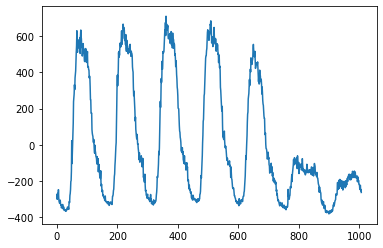

In [173]:
plt.plot(seasonal_factors[seasonal_factors["grid_sqaure"] == 5056]["seasonal_factors"])

In [174]:
plotting = final_grid.groupby("grid_square")

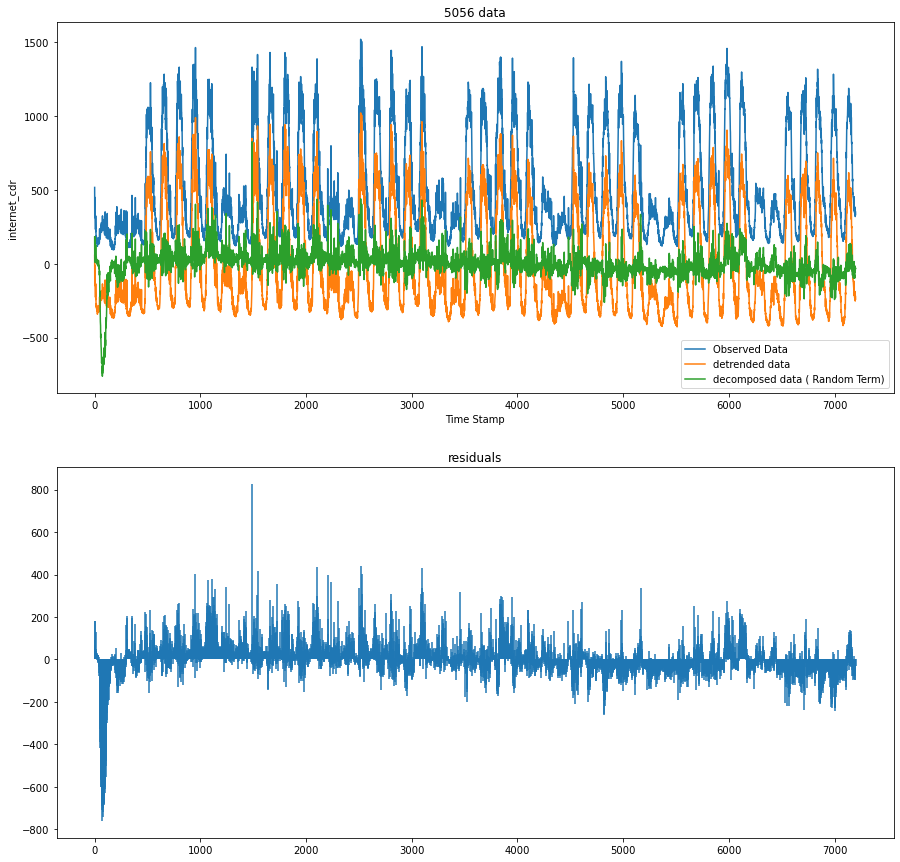

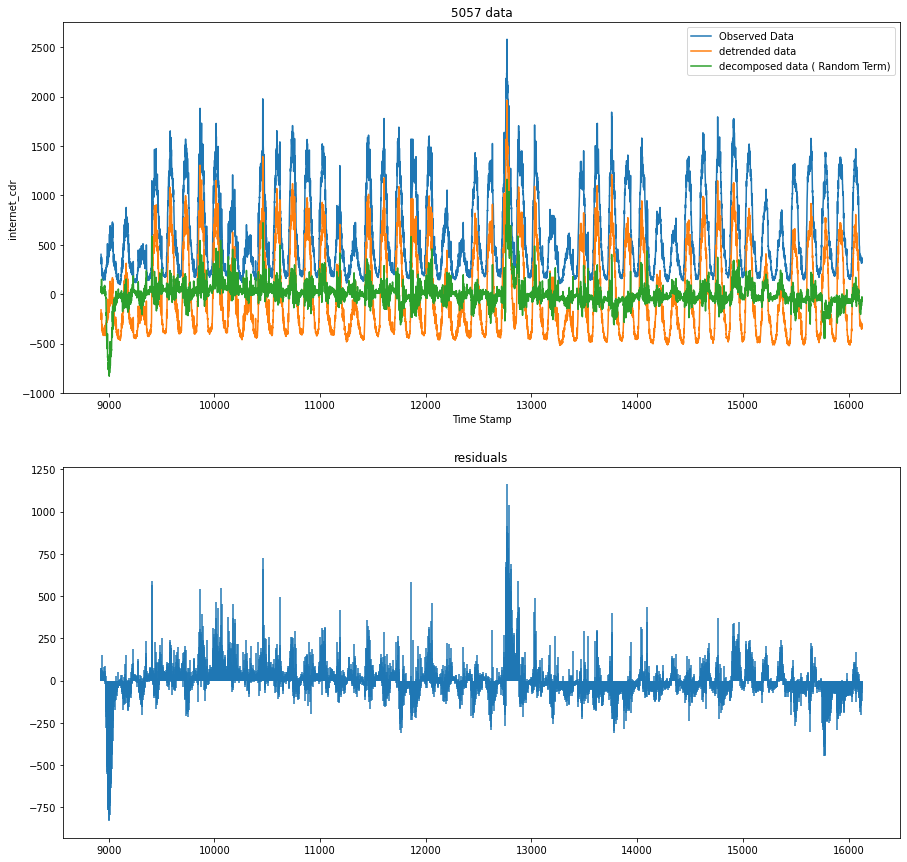

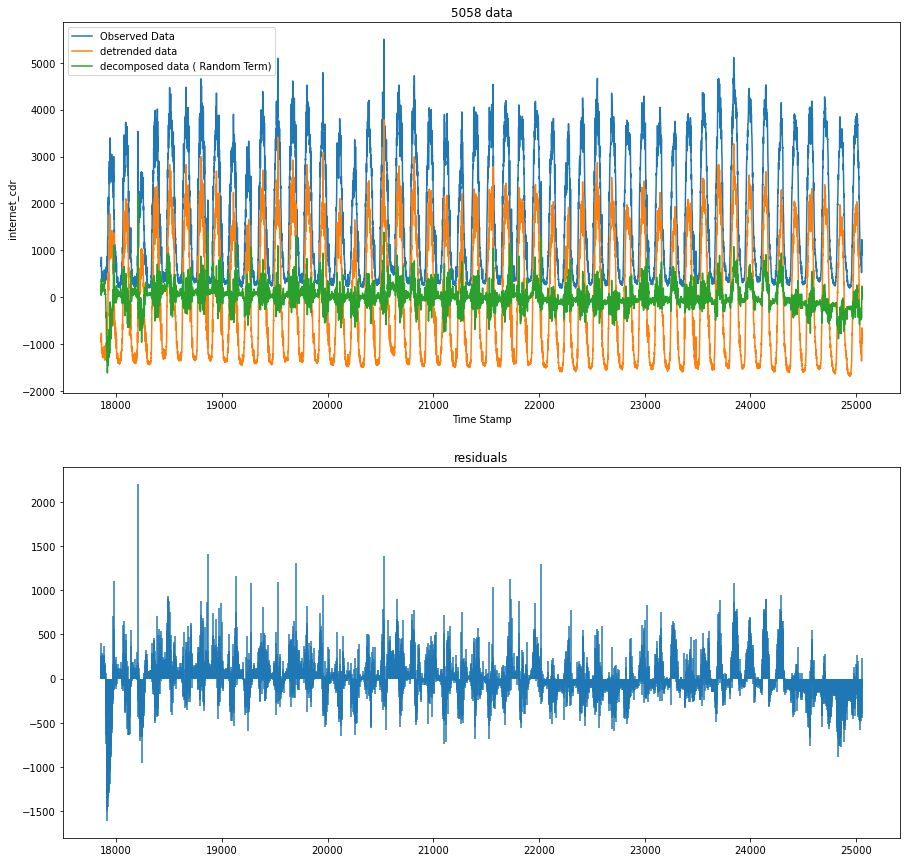

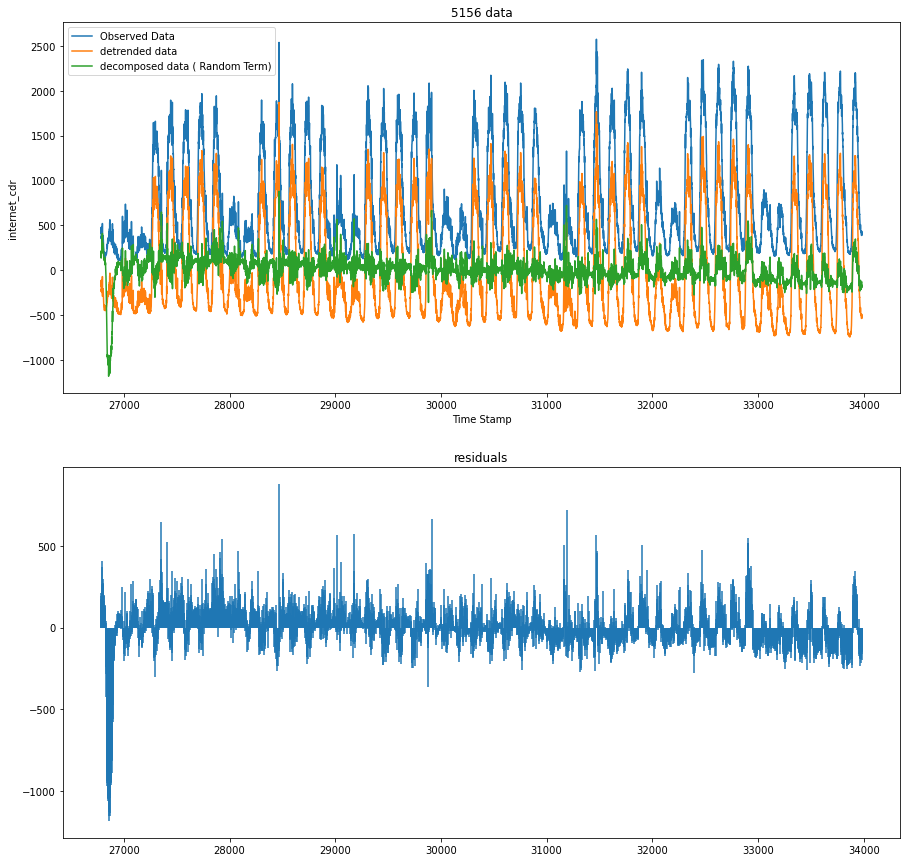

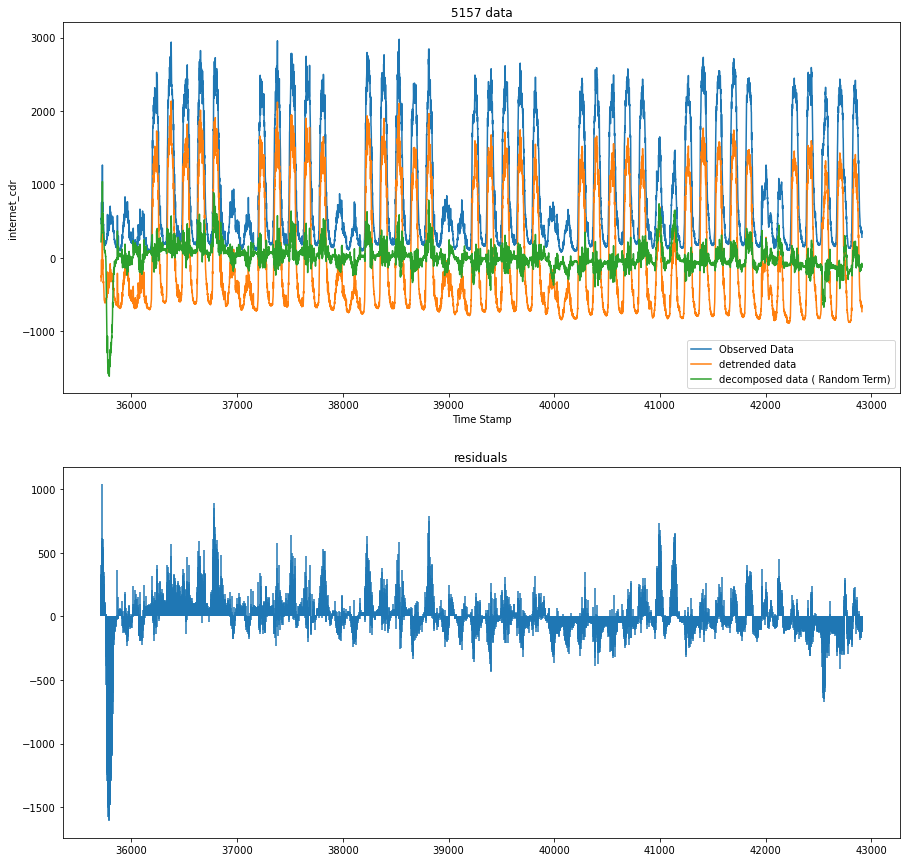

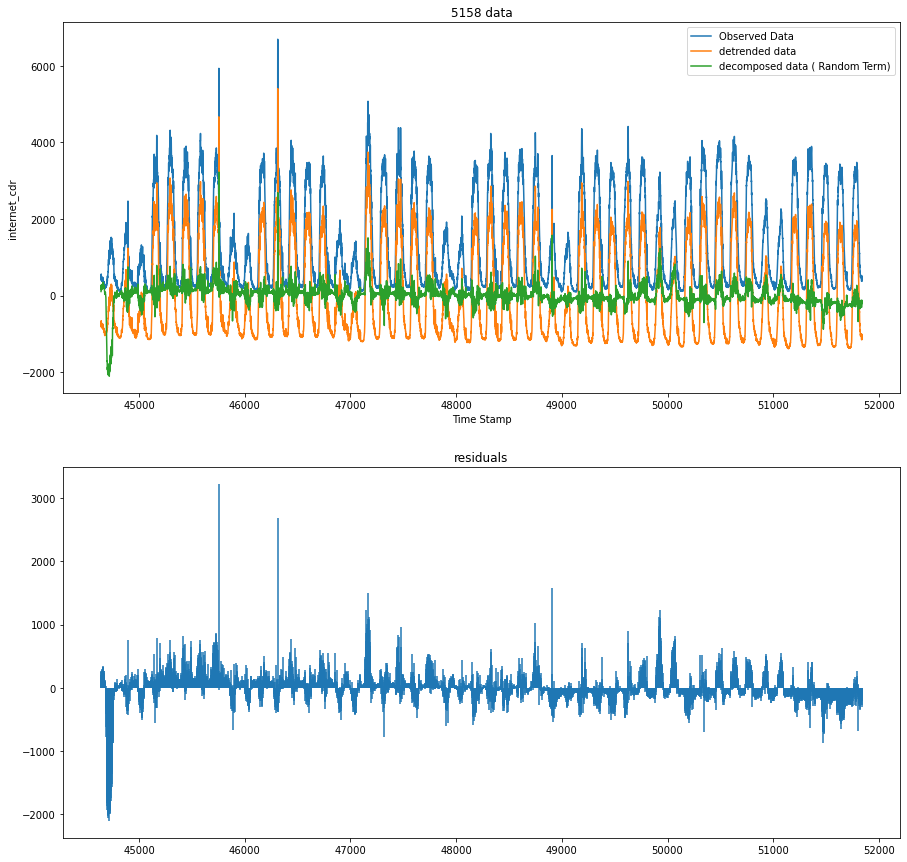

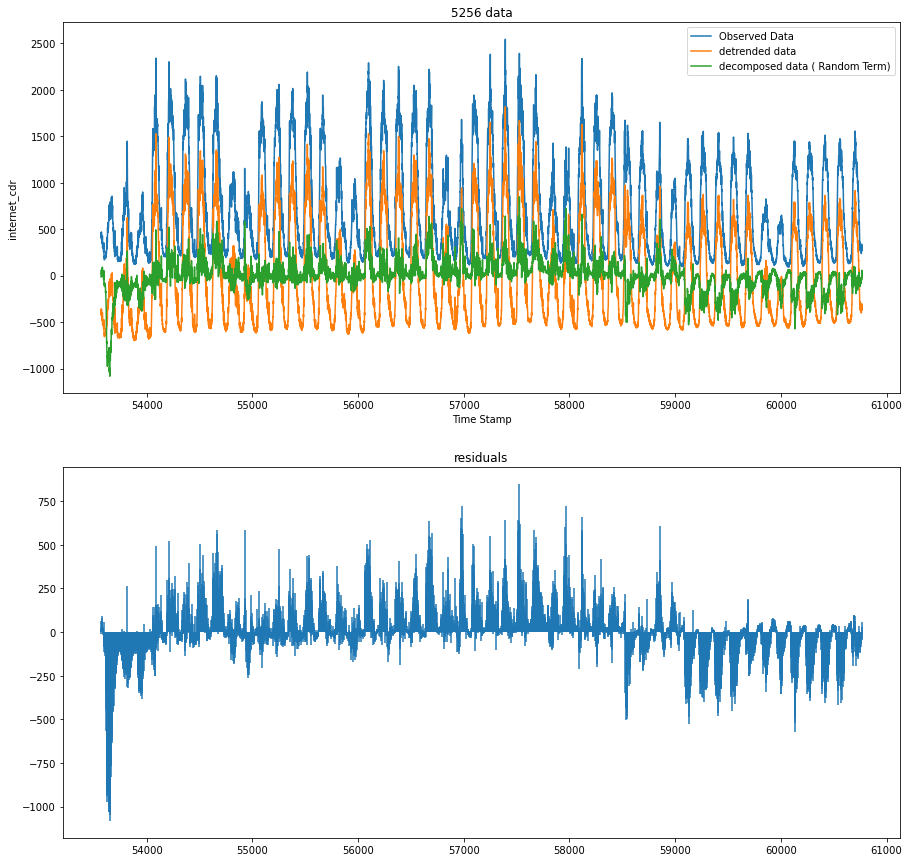

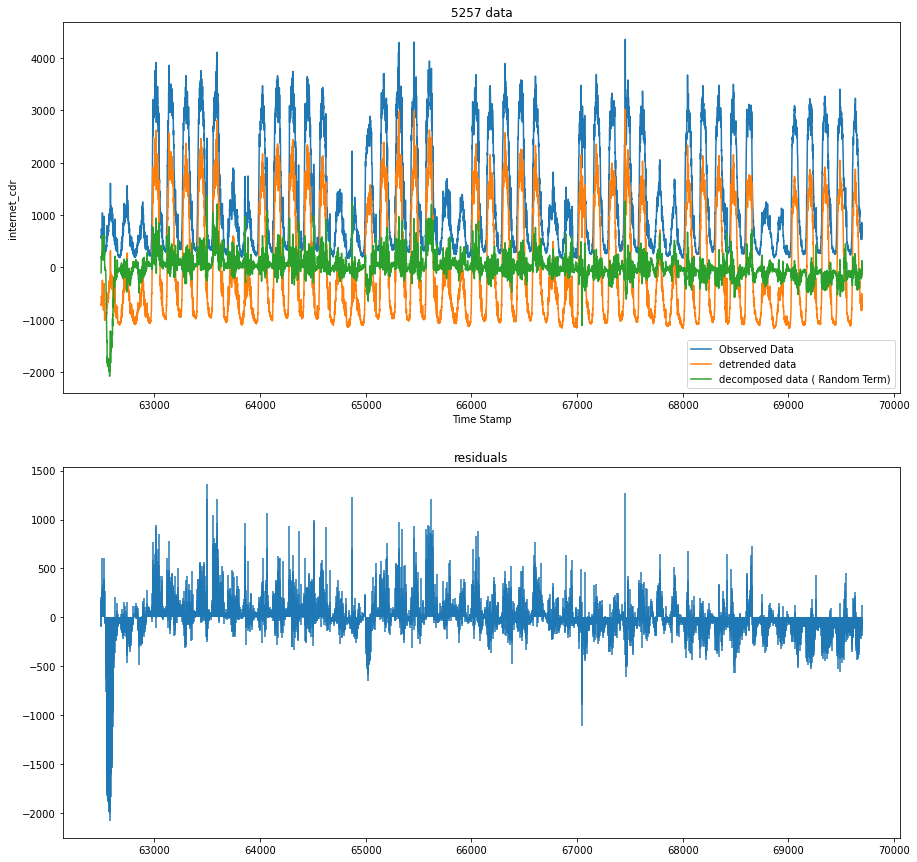

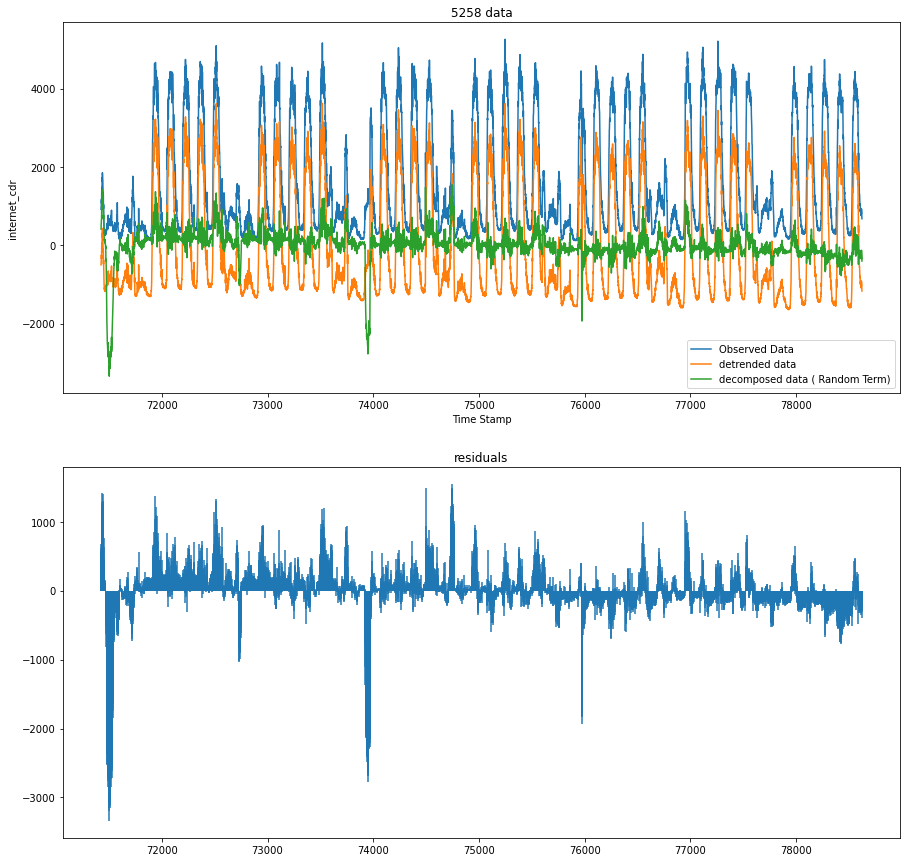

In [197]:
for grid in chosen_grids:
    p = plotting.get_group(grid)
    fig, axs = plt.subplots(2,1, figsize = (15,15))
    axs[0].plot(p["internet_cdr"], label = "Observed Data")
    axs[0].plot(p["detrended"], label = "detrended data")
    axs[0].plot(p["deseasonnal"], label = "decomposed data ( Random Term)")
    axs[0].set_xlabel("Time Stamp")
    axs[0].set_ylabel("internet_cdr")
    axs[0].set_title("{} data".format(grid))
    axs[0].legend()
    axs[1].vlines(list(p["internet_cdr"].index),[0]*len(p), p["deseasonnal"])
    axs[1].set_title("residuals")
    plt.show()

In [176]:
final_grid.to_csv("Decomposed_grids.csv", index = False)
seasonal_factors.to_csv("seasonal_factors.csv", index = False)

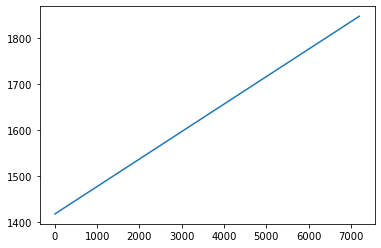

In [198]:
plt.plot(trend)